In [29]:
import edward as ed
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale
from edward.models import Normal
from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_style('white')

In [2]:
# ensure you are using TensorFlow as your Keras backend
sess = ed.get_session()
K.set_session(sess)

INIT_OP = tf.global_variables_initializer()

In [8]:
def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
    return df

# Loading Data

In [24]:
df_train = pd.read_csv('data/df_imp_col.csv')
df_train[list(df_train.columns)[:9]] = df_train[list(df_train.columns)[:9]].astype(int)
df_train = change_datatype(df_train)
print(df_train.shape)
df_train.head()

(83478, 13)


,area_total_calc,area_live_finished,num_bathroom,num_bathroom_calc,num_bath,num_bedroom,tax_building,build_year,region_zip,censustractandblock,logerror,latitude,longitude
0,1684,1684,2,2,2,3,122754,1959,96370,6.037107e+13,0.0276,34280990.0,-118488536.0
1,2217,2217,3,3,3,2,61994,1940,96293,6.037464e+13,-0.0040,34136312.0,-118175032.0
2,839,839,2,2,2,2,171518,1987,96222,6.037296e+13,0.0218,33755800.0,-118309000.0
3,2283,2283,2,2,2,4,169574,1981,96961,6.059042e+13,-0.0050,33485643.0,-117700234.0
4,3067,3067,4,4,4,4,880650,1982,96109,6.037621e+13,-0.2705,33870089.0,-118402768.0


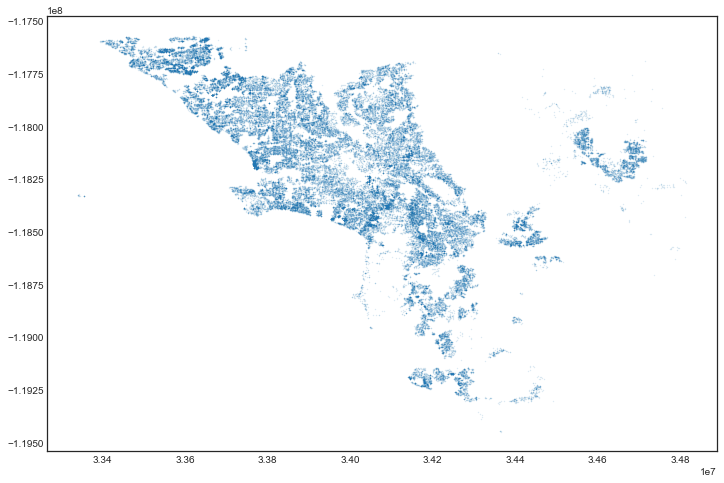

In [34]:
plt.figure(figsize = (12,8))
plt.scatter(df_train['latitude'], df_train['longitude'], s = 0.1, alpha = 0.2)

In [ ]:
# KL(q∥p) Minimization
# https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
# http://edwardlib.org/tutorials/klqp


In [ ]:
# https://www.kaggle.com/itoeiji/bayesian-neural-network-with-edward

import edward as ed
from edward.models import Normal, Categorical

x_ = tf.placeholder(tf.float32, shape=(None, in_size))
y_ = tf.placeholder(tf.int32, shape=(BATCH_SIZE))

w = Normal(loc=tf.zeros([in_size, out_size]), scale=tf.ones([in_size, out_size]))
b = Normal(loc=tf.zeros([out_size]), scale=tf.ones([out_size]))
y_pre = Categorical(tf.matmul(x_, w) + b)

qw = Normal(loc=tf.Variable(tf.random_normal([in_size, out_size])), scale=tf.Variable(tf.random_normal([in_size, out_size])))
qb = Normal(loc=tf.Variable(tf.random_normal([out_size])), scale=tf.Variable(tf.random_normal([out_size])))

y = Categorical(tf.matmul(x_, qw) + qb)

inference = ed.KLqp({w: qw, b: qb}, data={y_pre: y_})
inference.initialize()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = train_x[perm[i:i+BATCH_SIZE]]
            batch_y = train_y2[perm[i:i+BATCH_SIZE]]
            inference.update(feed_dict={x_: batch_x, y_: batch_y})
        y_samples = y.sample(samples_num).eval(feed_dict={x_: train_x})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == train_y2).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 1 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))